<a href="https://colab.research.google.com/github/Michaelnormantovich/Plant-disease-classifier/blob/main/leaf_classifier_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio numpy pandas kaggle

In [ ]:
#!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p ./data/
#!unzip ./data/plantvillage-dataset.zip -d ./data/plantvillage/
!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p ./data/
!unzip -q ./data/plantvillage-dataset.zip -d ./data/ # Extract to ./data/ instead of ./data/plantvillage/

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:37<00:00, 18.6MB/s]
100% 2.04G/2.04G [01:37<00:00, 22.5MB/s]


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10
Train Loss: 0.3560, Train Acc: 0.8711
Val Loss: 0.2209, Val Acc: 0.9164
Epoch 2/10
Train Loss: 0.2087, Train Acc: 0.9234
Val Loss: 0.1710, Val Acc: 0.9377
Epoch 3/10
Train Loss: 0.1547, Train Acc: 0.9424
Val Loss: 0.1446, Val Acc: 0.9473
Epoch 4/10
Train Loss: 0.1200, Train Acc: 0.9533
Val Loss: 0.1501, Val Acc: 0.9455
Epoch 5/10
Train Loss: 0.0941, Train Acc: 0.9622
Val Loss: 0.1274, Val Acc: 0.9532
Epoch 6/10
Train Loss: 0.0741, Train Acc: 0.9692
Val Loss: 0.1328, Val Acc: 0.9540
Epoch 7/10
Train Loss: 0.0606, Train Acc: 0.9735
Val Loss: 0.1341, Val Acc: 0.9550
Epoch 8/10
Train Loss: 0.0506, Train Acc: 0.9769
Val Loss: 0.1591, Val Acc: 0.9531
Epoch 9/10
Train Loss: 0.0438, Train Acc: 0.9793
Val Loss: 0.1643, Val Acc: 0.9507
Epoch 10/10
Train Loss: 0.0401, Train Acc: 0.9808
Val Loss: 0.1754, Val Acc: 0.9542
Training finished


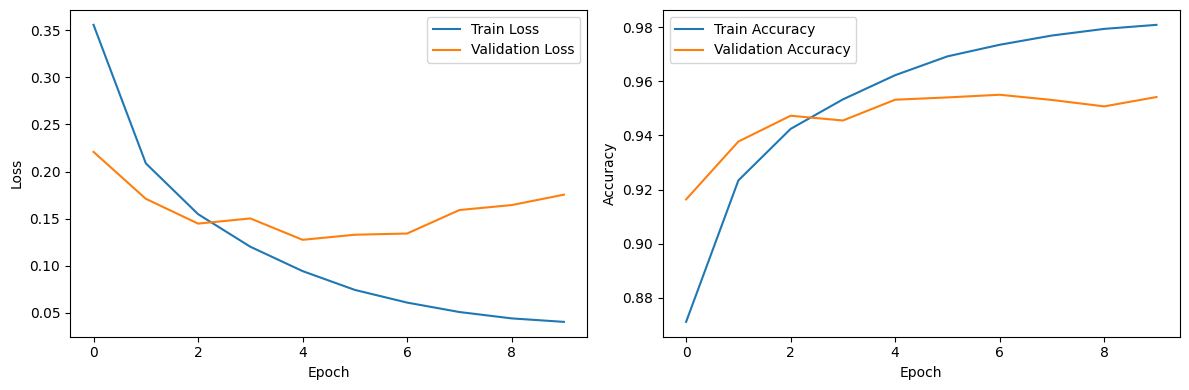

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load PlantVillage dataset (leaf images)
plant_village = torchvision.datasets.ImageFolder(root='./data/plantvillage dataset', transform=transform)
num_plant_classes = len(plant_village.classes)

# Load CIFAR-10 dataset (non-leaf images)
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Combine datasets and adjust labels
combined_dataset = ConcatDataset([
    plant_village,
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform,
                                 target_transform=lambda x: x + num_plant_classes)
])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Calculate total number of classes
total_classes = num_plant_classes + 10  # 10 for CIFAR-10

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load pre-trained ResNet18 model
model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("Training finished")

# Save the model
torch.save(model.state_dict(), 'leaf_classifier.pth')

# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# Function to test on real images
def test_image(image_path):
    model.eval()
    img = Image.open(image_path)
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    return "Leaf" if predicted.item() < num_plant_classes else "Not Leaf"

# Test the model on a real image
test_image_path = './image_2.jpg'
result = test_image(test_image_path)
print(f"The image is classified as: {result}")

The image is classified as: Leaf
